In [1]:
import glob
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import os
import oscdeeppy as odp
from importlib import reload
from tqdm.auto import tqdm

In [2]:
try:
    import cupy as nx
    from cupyx.scipy.signal import fftconvolve
    from scipy.ndimage import gaussian_filter
    from scipy.optimize import minimize
    __cupy = True
except:
    import numpy as nx
    from scipy.signal import fftconvolve
    from scipy.ndimage import gaussian_filter
    from scipy.optimize import minimize
    __cupy = False
print(f'Using Cupy: {__cupy}')

Using Cupy: True


/mnt/scratch/astropy/astropy-venv/lib/python3.13/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
DTYPE=np.float32

# These images were created with Siril calibration and registration with interpolation
r_lights = glob.glob('../astro/2025_Cassiopeias_Ghost/process/r_debayer_ic63_*.fit')

r_light_set = odp.FITSSet(r_lights, transpose=(1,2,0))

In [4]:
r_light_set.img_shape

(4176, 6248, 3)

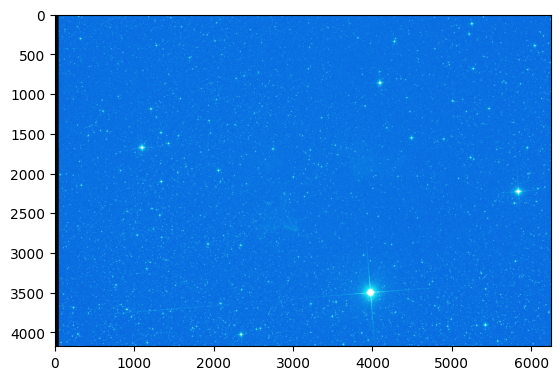

In [5]:
odp.display_stf(r_light_set[0])

In [6]:
img = r_light_set[0]
print(np.min(img))
print(np.max(img))
print(np.count_nonzero(img == 0))
print(np.count_nonzero(img != 0))

0.0
1.4921467
658653
77616291


In [7]:
gauss_residual_fn = odp.gauss_residual_fn
gauss_profile = odp.gauss_profile

In [8]:
%prun psf = odp.find_stars(img,make_psf=True,num_stars=300,clip_cut=0.85,fast_fit=False)

         4919559 function calls (4919556 primitive calls) in 9.711 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   279768    3.564    0.000    3.564    0.000 alignment.py:65(gauss_profile)
    30498    1.016    0.000    7.038    0.000 _optimize.py:2497(optimize)
   279768    0.803    0.000    5.139    0.000 alignment.py:75(fn)
        4    0.541    0.135    0.541    0.135 {built-in method scipy.ndimage._nd_image.correlate1d}
        9    0.425    0.047    0.425    0.047 {built-in method time.sleep}
        1    0.425    0.425    0.425    0.425 {method 'tolist' of 'numpy.ndarray' objects}
   279768    0.313    0.000    5.661    0.000 _optimize.py:555(function_wrapper)
   315902    0.298    0.000    0.298    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   275639    0.295    0.000    5.867    0.000 _optimize.py:3235(myfunc)
        4    0.250    0.062    0.791    0.198 _filters.py:555(correlate1d)
   281518    0.245    

# PSF

In [10]:
def get_img_psf(img, verbose=False, **kwargs):
    psfs = []
    for ch in range(img.shape[-1]):
        if verbose: print(f'Processing channel {ch}')
        psfs.append(find_stars(img[...,ch], make_psf=True, registration_channel=None, **kwargs))
    return np.transpose(psfs,(1,2,0))

In [11]:
def ExtractPSFs(image_set, selection=None, num_stars=300, clip_cut=0.85):    
    print(f'Computing image PSFs')
    with odp.ImageProcessor(nproc=12) as proc:
        # These could be saved to disk if too big
        PSFs = proc.map(get_img_psf, image_set, num_stars=num_stars, clip_cut=clip_cut, selection=selection, progress=True)

    return PSFs

In [12]:
selection = np.zeros(len(r_light_set),dtype=bool)
selection[:20] = True

In [13]:
PSFs = ExtractPSFs(r_light_set, selection=selection)

Computing image PSFs


  0%|          | 0/20 [00:00<?, ?it/s]

[0.9999999  0.99999994 1.        ]


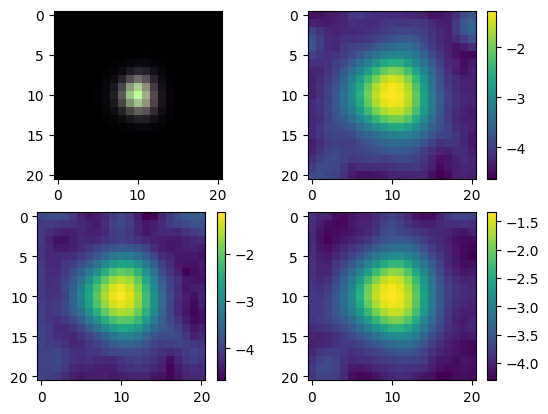

[0.9999998 1.0000001 1.0000001]


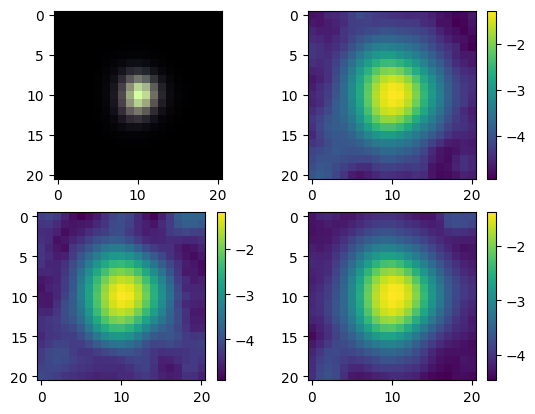

In [14]:
for i in range(0,2):
    psf = np.asarray(PSFs[i])
    print(np.sum(np.sum(psf, axis=0), axis=0))

    plt.subplot(2,2,1)
    plt.imshow(psf/np.max(psf))
    
    for ch in range(3):
        plt.subplot(2,2,ch+2)
        plt.imshow(np.log10(psf[...,ch]))
        plt.colorbar()

    plt.show()
    plt.close()

# ImageMM

Trying to make this more portable

In [37]:
def conv2(x, k):
    return fftconvolve(x, k, mode='same')

def conv2_T(x, k):
    # Adjoint convolution: correlate with flipped kernel
    k_flip = nx.flip(k)
    return fftconvolve(x, k_flip, mode='same')

class ImageMM_Util:

    def __init__(self, image_set, psfs, selection=None, gamma=1.0, kappa=2.0):
        self.image_set = image_set
        self.psfs = psfs
        self.selection = selection
        self.gamma = gamma 
        self.kappa = kappa
        self.ch = 1
        self.img_shape = self.image_set.img_shape
        self.x_guess = None

    def set_ch(self, ch):
        self.ch = ch

    def set_guess(self, guess):
        self.x_guess = guess

    def y_t(self, t):
        img = nx.array(self.image_set[t][..., self.ch])
        return img

    def F_t(self, t):
        psf = nx.array(self.psfs[t][..., self.ch])
        # I find overestimating the size of the PSF makes bad ringing 
        # The gamma parameter can shrink it back down a bit to _reduce_ how much sharper the latent image must be
        psf = nx.power(psf,self.gamma)
        return psf/nx.sum(psf)

    # the paper chose to write this as a more general matrix operation on a 1D image, which is impossible to implement
    # i'll use discrete ffts to do fast convolutions on 2d images without blowing up the memory requirements
    
    def y_F_W(self, t):
        # the image, in 2d instead of the 1d notation from the paper
        y = self.y_t(t)
    
        # this image's PSF as a 2d kernel
        F = self.F_t(t)
        
        # images may have missing data
        masked = nx.logical_or(nx.isnan(y), y <= 0)
        y[masked] = -1
        
        # this is assuming modeled random noise is of the background
        # there's some overall proprtionality here, but it would (?) cancel out in the numerator and denominator
        W = nx.where(masked,0,1)/np.median(y) 

        # the signal extraction only makes sense on background extracted images, but the color channels may have a relative offset
        y = y - nx.median(y) + 0.1
        
        return y, F, W
        
    # Compute num and den for update image u_k = (sum F_t^T W_t y_t) / (sum F_t^T W_t F_t x_k-1)
    # split into separate functions, as num is constant wrt k
    
    def u_k_num(self, t):
        y,F,W = self.y_F_W(t)
        return conv2_T(W * y, F)
    
    def u_k_den(self, t):
        _,F,W = self.y_F_W(t)
        return conv2_T(W * conv2(self.x_guess, F), F)

def ImageMM(image_set, psfs, selection=None, gamma=1.0, kappa=2.0, tol=1e-4, max_it=20, cropper=None, snapshots=False, extra=False, verbose=False):
    '''
    ImageMM as described by the original authors https://arxiv.org/pdf/2501.03002 is a method to achieve a maximum likelihood
    extraction of the true sky which produced a sequence of individual exposures of the sky. Each image in the sequence
    has its own Point Spread Function which is convolved with a guess of the true sky to quantify the likelihood of that guess.
    The technique presented in that paper to find a global maximum likelihood through an ancillary update rule (u_k) makes
    this signal extraction tractable, even when there are O(10^6) free parameters. 
    '''

    if cropper is None: cropper = lambda x: x
    
    if selection is None:
        selection = np.ones(len(image_set),dtype=bool)
    t_valid = np.argwhere(selection).flatten().tolist()
    n_t = len(t_valid)

    assert len(image_set) == len(psfs), 'Images and PSFs must be the same length'

    mm = ImageMM_Util(image_set, psfs, selection, gamma, kappa)
            
    latent_image = np.empty(mm.img_shape, dtype=DTYPE) # result is always on host
    snapshots = [[],[],[]] if snapshots else None
    
    for ch in range(1):#mm.img_shape[-1]):

        mm.set_ch(ch)
        if verbose: print(f'Processing channel {ch}')
        
        # for some pixel-level statistics
        y_sum = nx.zeros_like(mm.y_t(0))
        norm = nx.zeros_like(y_sum)
        
        for t in t_valid:
            y = mm.y_t(t)
            # images may have missing data
            masked = nx.logical_or(nx.isnan(y), y == 0)
            y[masked] = -1
            y_sum += y
            norm += nx.where(masked,0,1)
            
        valid = norm > 0
        if not np.all(valid):
            print('There are unconstrained pixels in the latent image')
                
        if verbose: print(f'Max-likelihood extraction on {n_t} images')
        
        # initialize x_guess to a naive average stack
        x_guess = y_sum/np.clip(norm,1,None)
        x_guess = np.clip(x_guess-np.median(x_guess)+3*np.std(x_guess),1e-12,None)
        
        if snapshots:
            snapshots[ch].append(x_guess.copy() if not __cupy else x_guess.get())
        if verbose:
            display(odp.display_stf(cropper(np.asarray(x_guess if not __cupy else x_guess.get())),plot=False))
        
        if verbose: print(f'Precomputing u_k numerator')
        
        num = nx.zeros_like(x_guess)
        
        pbar = tqdm(total=n_t)
        if __cupy:
            for t in t_valid:
                num += mm.u_k_num(t)
                pbar.update(1)
        else:
            with mp.Pool(processes=16) as p:
                r_it = p.imap_unordered(mm.u_k_num, t_valid, chunksize=1)
                for result in r_it:
                    num += result
                    pbar.update(1)
        pbar.close()
        
        if verbose: print(f'Num Mean: {np.mean(num)}')
        
        for k in range(1,max_it+1): 
            
            if verbose: print(f'Starting iteration {k}')

            mm.set_guess(x_guess)
            
            den = np.zeros_like(x_guess)
            pbar = tqdm(total=n_t)
            if __cupy:
                for t in t_valid: #TODO this is fully parallelizable 
                    den += mm.u_k_den(t)
                    pbar.update(1)
            else:
                with mp.Pool(processes=16) as p:
                    r_it = p.imap_unordered(mm.u_k_den, t_valid, chunksize=1)
                    for result in r_it:
                        den += result
                        pbar.update(1)
            pbar.close()
        
            den = nx.maximum(den, 1e-12)
            u_k = nx.clip(num / den, 1/kappa, kappa)
            
            if verbose: print(f'Den Mean: {np.mean(den)} => u_k Mean: {np.mean(u_k)}')
        
            # Copy to check convergence of clipped update image
            x_prev = x_guess.copy()
        
            # Multiplicative update
            x_guess *= u_k
            x_guess = nx.maximum(x_guess, 0.0)
            
            if snapshots:
                snapshots[ch].append(x_guess.copy() if not __cupy else x_guess.get())
            if extra:
                display(odp.display_stf(cropper(np.asarray(x_guess if not __cupy else x_guess.get())),plot=False))

            valid = x_guess > 0
            diff = nx.mean(nx.abs(x_guess[valid] - x_prev[valid])/x_guess[valid])
            print(f'Err: {diff}')
            if diff < tol:
                break
                
        latent_image[...,ch] = x_guess.copy() if not __cupy else x_guess.get()
        
        if verbose and not extra:
            display(odp.display_stf(cropper(latent_image)[...,ch],plot=False))
        
    if snapshots:
        return latent_image, snapshots
    else:
        return latent_image

In [38]:
PSFs_degen = np.ones((len(r_light_set),1,1,3),dtype=DTYPE)

(80, 25, 25, 3)

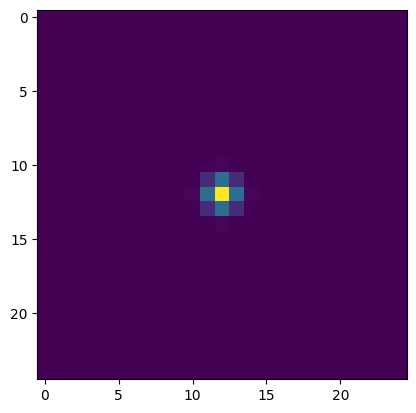

In [39]:
x = np.linspace(-12,12,25)
y = np.linspace(-12,12,25)
x,y = np.meshgrid(x,y)
psf = gauss_profile(x,y,0,0,0.7,0.7,0,1,0)
psf = psf/np.sum(psf)
plt.imshow(psf)
PSFs_fake = np.asarray([np.transpose([psf]*3,(1,2,0))]*len(r_light_set))
PSFs_fake.shape

Processing channel 0
Max-likelihood extraction on 80 images


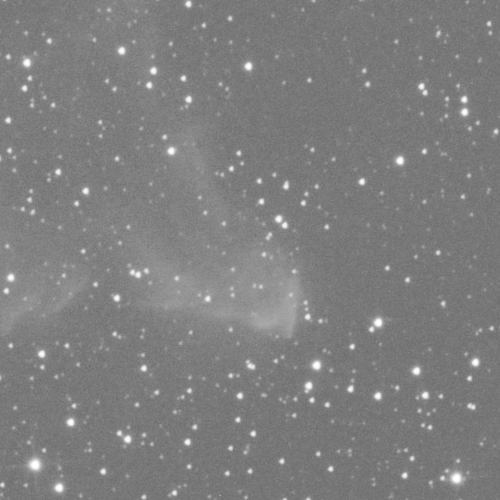

Precomputing u_k numerator


  0%|          | 0/80 [00:00<?, ?it/s]

Num Mean: 212.87025451660156
Starting iteration 1


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 716.588623046875 => u_k Mean: 0.5389699339866638


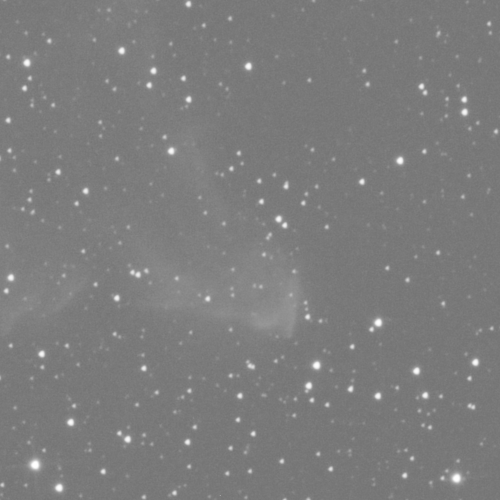

Err: 0.979752779006958
Starting iteration 2


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 359.6231689453125 => u_k Mean: 0.6188883781433105


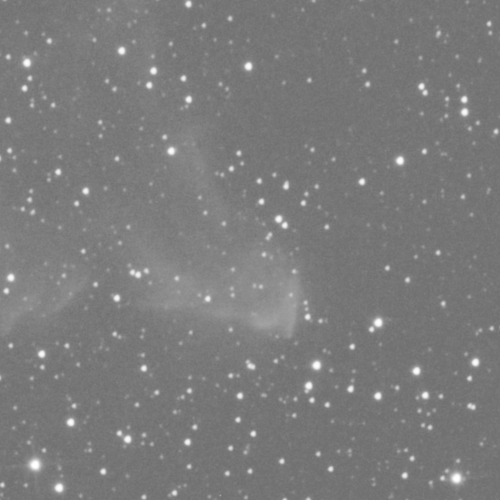

Err: 0.7079287767410278
Starting iteration 3


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.33396911621094 => u_k Mean: 1.0204029083251953


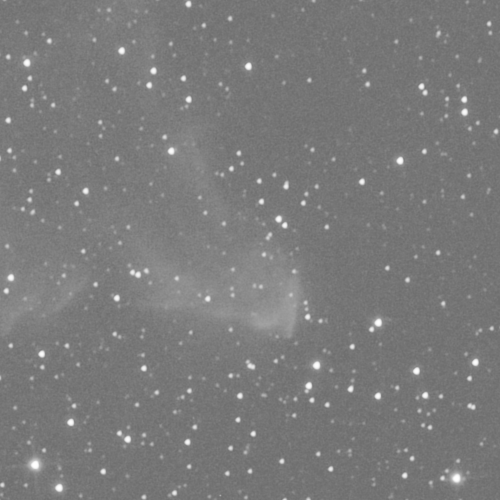

Err: 0.011436454020440578
Starting iteration 4


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.38539123535156 => u_k Mean: 1.0199253559112549


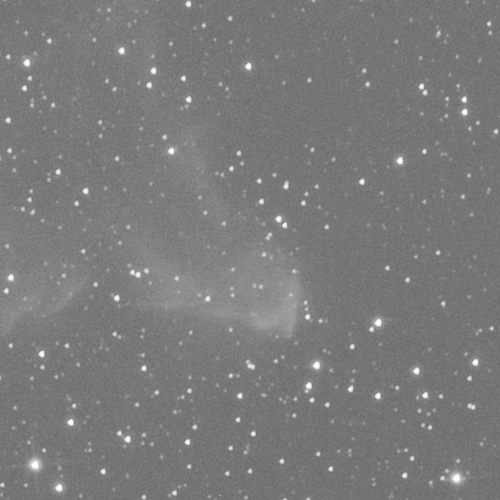

Err: 0.01068885624408722
Starting iteration 5


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.39930725097656 => u_k Mean: 1.0198460817337036


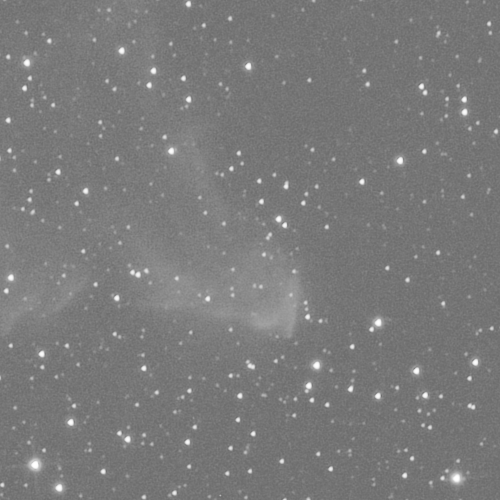

Err: 0.010448510758578777
Starting iteration 6


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40304565429688 => u_k Mean: 1.0198333263397217


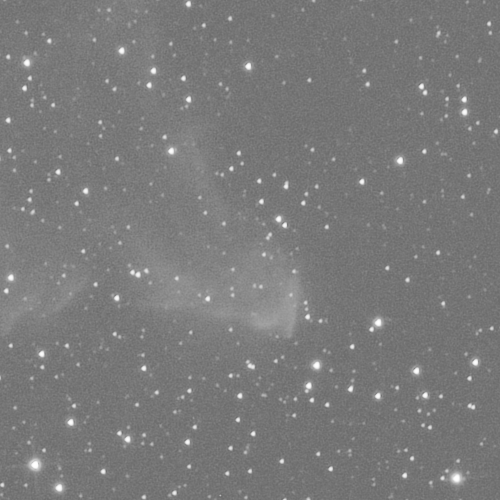

Err: 0.010324343107640743
Starting iteration 7


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.4049072265625 => u_k Mean: 1.0198293924331665


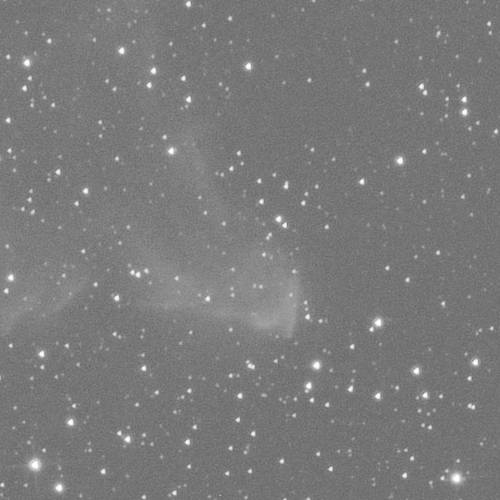

Err: 0.010248386301100254
Starting iteration 8


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40599060058594 => u_k Mean: 1.0198276042938232


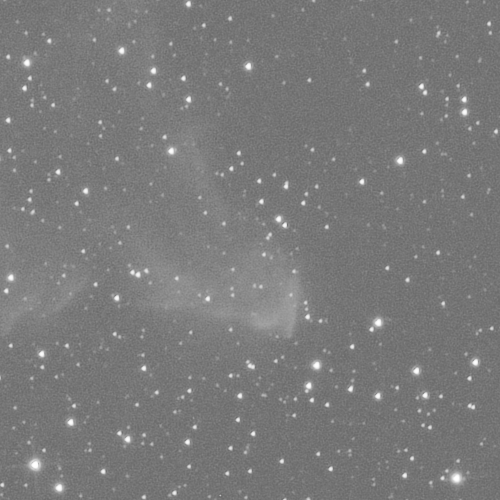

Err: 0.010200216434895992
Starting iteration 9


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.4066925048828 => u_k Mean: 1.0198265314102173


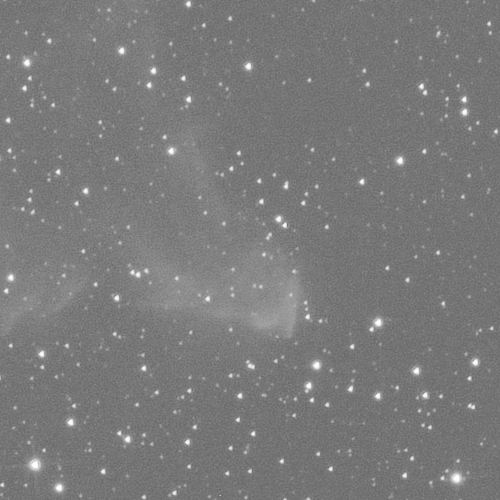

Err: 0.010165082290768623
Starting iteration 10


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.4072265625 => u_k Mean: 1.0198256969451904


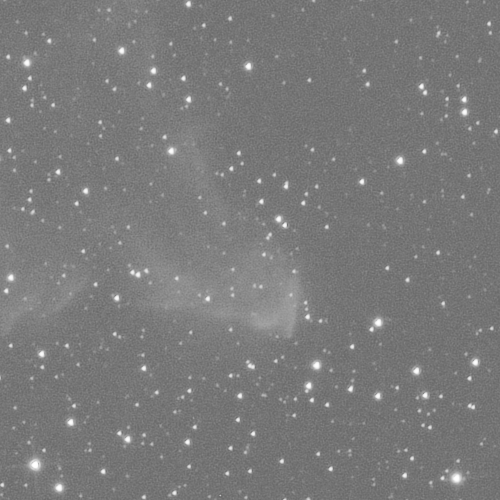

Err: 0.010137954726815224
Starting iteration 11


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40762329101562 => u_k Mean: 1.0198252201080322


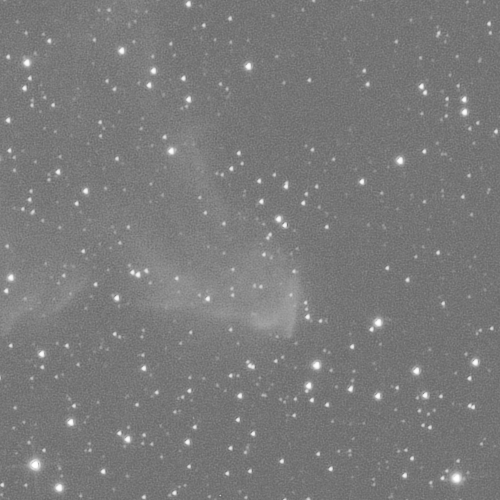

Err: 0.01011624839156866
Starting iteration 12


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40798950195312 => u_k Mean: 1.019824743270874


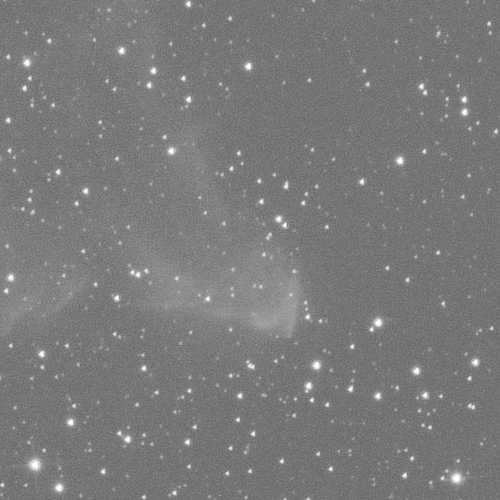

Err: 0.01009862869977951
Starting iteration 13


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40823364257812 => u_k Mean: 1.019824504852295


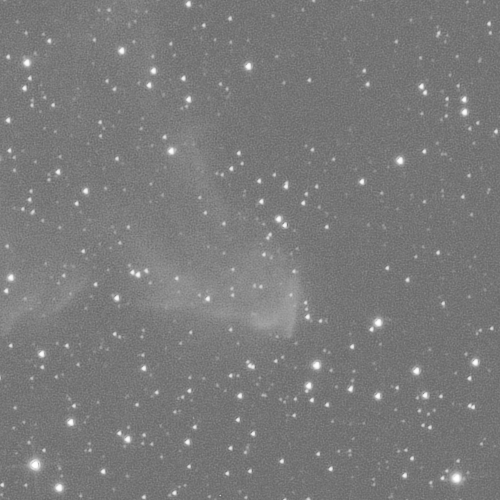

Err: 0.010084215551614761
Starting iteration 14


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40846252441406 => u_k Mean: 1.0198241472244263


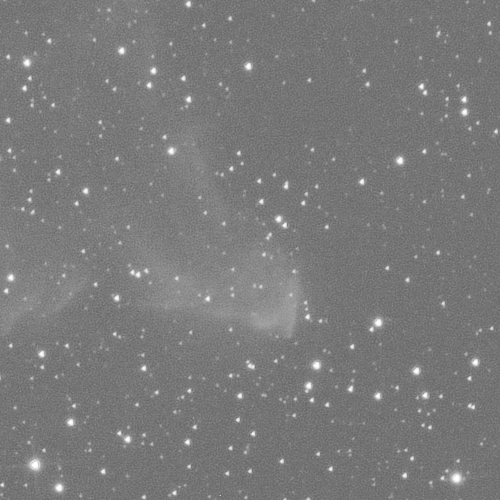

Err: 0.010072028264403343
Starting iteration 15


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.4086151123047 => u_k Mean: 1.0198235511779785


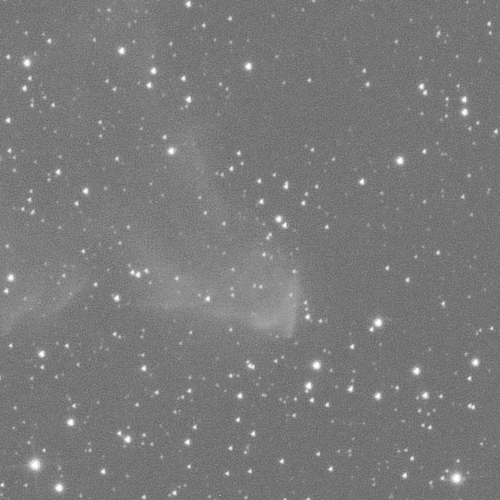

Err: 0.010061428882181644
Starting iteration 16


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40879821777344 => u_k Mean: 1.0198224782943726


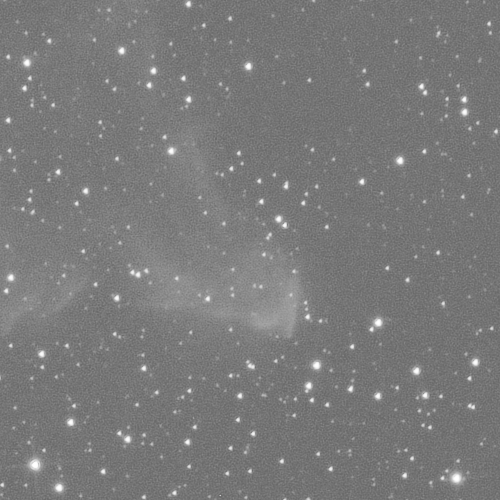

Err: 0.01005209144204855
Starting iteration 17


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40892028808594 => u_k Mean: 1.0198217630386353


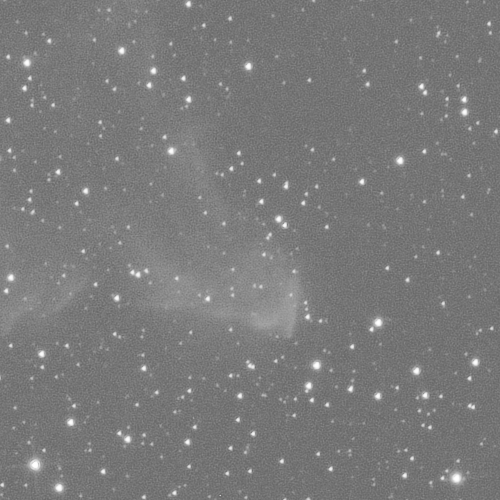

Err: 0.010043752379715443
Starting iteration 18


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40899658203125 => u_k Mean: 1.0198209285736084


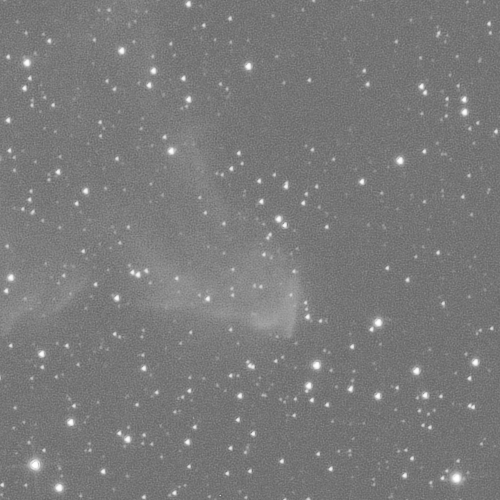

Err: 0.010036255232989788
Starting iteration 19


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.4091339111328 => u_k Mean: 1.0198196172714233


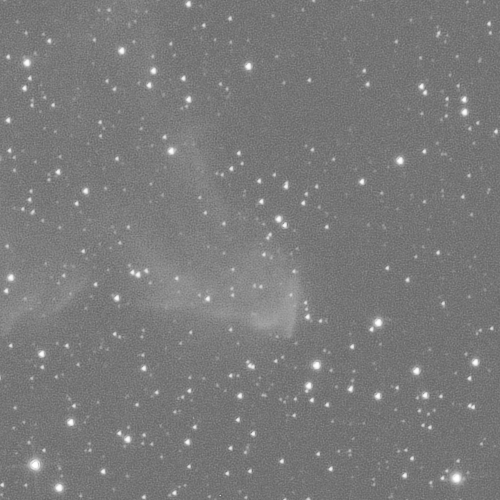

Err: 0.010029436089098454
Starting iteration 20


  0%|          | 0/80 [00:00<?, ?it/s]

Den Mean: 210.40921020507812 => u_k Mean: 1.0198181867599487


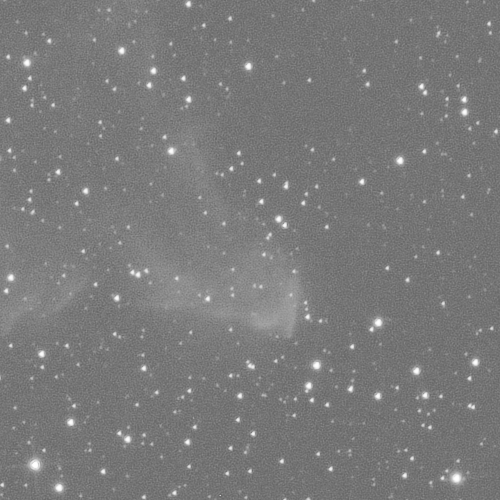

Err: 0.01002319622784853


In [40]:
latent_image, snapshots = ImageMM(r_light_set, PSFs_fake, gamma=1.0, tol=1e-3, max_it=20, selection=None, snapshots=True, verbose=True, extra=True, cropper=(lambda x: x[2400:2900,2750:3250]))

In [41]:
odp.display_stf(snapshots[0][0][...],save='latent_start.png',plot=False)
None

In [42]:
odp.display_stf(snapshots[0][-1][...],save='latent_end.png',plot=False)
None